# Analyzing StrainFinder results using combined samples

1. Do we also need to redo the flexible genome analysis using these combined samples?
2. We'll look at the engraftment of strains using the combined samples, using pretty aggressive cutoffs for ones where we think the results are valid
3. We'll also create a new type of plot that retains the information about the absolute abundance at each time point, which will provide a better interpretation of the faith in each time point.

On point 3, this is a bit harder to imagine how to do correctly than at first glance. For one, the samples are collapsed together, so one would need to figure out how to account for the fact that there are a variable number of samples and reads going into each value.

## Getting BIC and AIC values

In Python2

In [ ]:
import cPickle, os, numpy as np, pandas as pd
from collections import defaultdict
#change directory and import strainfinder functions
os.chdir('/home/ubuntu/users/ndchu/scripts/deepdive')
from StrainFinder import *
import shutil

In [ ]:
#set up files
in_dir = '/home/ubuntu/ebs/ndchu_sf/sf_output/results_2019-04-15/sf'
os.chdir(in_dir)
em_files = [x for x in os.listdir('.') if x.endswith('.cpickle')]

#get other file information
gens = [x.split('_month')[0] for x in em_files]
n_str = [x.split('nstrains_')[1].split('_')[0] for x in em_files]

#read files
ems = [cPickle.load(open(fn, 'rb')) for fn in em_files]
#get aics
aics = [em.select_best_estimates(1)[0].aic for em in ems]
bics = [em.select_best_estimates(1)[0].bic for em in ems]

#make a dataframe of these values
ic_df = pd.DataFrame({'file': em_files,
                      'genome': gens,
                      'n_strains': n_str,
                      'aic': aics,
                      'bic': bics})
#write to a file
ic_df.to_csv('/home/ubuntu/tmp/' + 'ic_em_values.tsv',
             sep='\t', index=False)

In [ ]:
#copy the min bic files to a temporary folder
tmp_out = '/home/ubuntu/tmp/sf_tmp'
for gen, sub_df in ic_df.groupby('genome'):
    min_bic = sub_df.loc[sub_df['bic'] == sub_df['bic'].min()]
    em_file = min_bic['file'].iloc[0]
    otu_file = em_file.split('_em_file.cpickle')[0] + '_otu_table.txt'
    otu_path = in_dir + '/' + otu_file
    out_path = tmp_out + '/' + otu_file
    shutil.copyfile(otu_path, out_path)

## Looking at read depths

In [3]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
#make a dictionary of colors for bacterial sources
src_set_clrs = {'shared': (0.878, 0.878, 0.878),
              'patient': (0.909, 0.470, 0.470),
              'env': (0.933, 0.674, 0.349),
              'donor0044': (0.305, 0.749, 0.776),
              'donor0073s': (0.643, 0.450, 0.850),
              'donor0044_0073': (0.376, 0.470, 0.803),
              'donor_any': (0.376, 0.470, 0.803),
              'donor': (0.376, 0.470, 0.803)}

In [5]:
#read in metadata
md = pd.read_csv('/Users/ndchu/Documents/uc_fmt/metadata/metadata_stool_dna_NV022018.tsv',
                 sep='\t', dtype={'patient': 'object',
                                  'fmt': 'object',
                                  'fmt_induction': 'object'})
md.loc[:, 'patient_plt'] = 'patient_' + md['patient']

#read in patient metadata
md_pat = pd.read_csv('/Users/ndchu/Documents/uc_fmt/metadata/metadata_patients_2019-04-10.tsv',
                     sep='\t', dtype={'patient': 'object',
                                      'fmt': 'object',
                                      'fmt_induction': 'object'})

In [6]:
patient_ids = md_pat.set_index('patient').to_dict()['label_pub']

In [7]:
s_file_dir = '/Users/ndchu/Documents/uc_fmt/metagenomics/strain_finder/comb_sam_2019-04-15'
otu_file_dir = '/Users/ndchu/Documents/uc_fmt/metagenomics/strain_finder/results_2019-04-15'

s_files = sorted([x for x in os.listdir(s_file_dir) if x.endswith('txt')])
otu_files = sorted([x for x in os.listdir(otu_file_dir) if x.endswith('txt')])
gens = [x.split('_month')[0] for x in otu_files]

In [8]:
#get the actual taxonomic names of these bacteria
gen_map = pd.read_excel('/Users/ndchu/Documents/uc_fmt/metagenomics/strain_finder/smilie_etal2018_genomes.xlsx')

bact_id_to_gen = gen_map.set_index('BACT ID').to_dict()['Genome']

### Plot Faecalibacterium as a pilot

In [185]:
def ts_cat(x):
    if x <= -5:
        return 'baseline'
    elif -5 < x <= 1:
        return 'abx'
    elif 1 < x <= 28:
        return 'month_1'
    elif 28 < x <= 56:
        return 'month_2'
    elif 56 < x <= 84:
        return 'month_3'
    elif 84 < x:
        return 'follow_up'

md.loc[:, 'ts_comb'] = md['days_past_fmt'].apply(lambda x: ts_cat(x))

In [186]:
#get total mgx reads per sample for normalizing read depths
md_mgx = md.loc[md['reads_mgx'] > 0]
tmp = md_mgx['ts_comb'].fillna('')
md_mgx.loc[:, 'sample_ts_comb'] = md_mgx['patient'].str.cat(tmp, sep='_')
md_mgx.loc[:, 'sample_ts_comb'] = md_mgx['sample_ts_comb'].replace({'0044_': '0044', #fix donors
                                                                    '0073_': '0073'})
#sum up reads
mgx_read_depth = md_mgx.groupby('sample_ts_comb').sum()['reads_mgx']

In [187]:
#make a metadata table for these combined samples
md_ts_comb = md_mgx[['sample_ts_comb', 'patient_donor', 'patient', 
                     'treatment', 'fmt_induction', 'clinical_intervention',
                     'responder_fmt', 'patient_plt', 'ts_comb']].drop_duplicates()

#add an approximate time for all samples, using the end of the period
md_ts_comb.loc[:, 'approx_day'] = md_ts_comb['ts_comb'].replace({'baseline': -8,
                                                                  'abx': 0,
                                                                  'month_1': 28,
                                                                  'month_2': 56,
                                                                  'month_3': 84,
                                                                  'follow_up': 140})

In [188]:
s_file = s_files[-1]
otu_file = otu_files[-1]
gen = gens[-1]

#read in files
sam_df = pd.read_csv(f'{s_file_dir}/{s_file}', sep='\t',
                     dtype={'patient': object})
otu_df = pd.read_csv(f'{otu_file_dir}/{otu_file}', sep='\t')

#add sample info, doing donors by hand
sam_df.loc[:, 'patient'] = sam_df['patient'].apply(lambda x: x.zfill(3))
sam_df.loc[:, 'patient'] = sam_df['patient'].replace({'044': '0044', #fix donors
                                                      '073': '0073'})
sam_df.loc[:, 'ts_group'] = sam_df['ts_group'].fillna('')
sam_df.loc[:, 'sample'] = sam_df['patient'].str.cat(sam_df['ts_group'], sep='_')
sam_df.loc[:, 'sample'] = sam_df['sample'].replace({'0044_': '0044', #fix donors
                                                    '0073_': '0073'})
otu_df.index = sam_df['sample']

#swap otu labels
seq_to_label = {seq: f'strain_{x}' for x, seq in zip(range(otu_df.shape[1]), otu_df.columns)}
otu_df.columns = [seq_to_label[x] for x in otu_df.columns]

#make a table of abundance normalized by median read depth across sites
otu_mednorm = otu_df.multiply(sam_df.set_index('sample')['quantile_50'], axis=0)

In [189]:
#make a tidy frame
mednorm_tidy = pd.melt(otu_mednorm.reset_index(), 
                       id_vars='sample', var_name='strain_label',
                       value_name='median_norm_abun')

#add metadata
mednorm_tidy = mednorm_tidy.merge(md_ts_comb, 
                                  left_on='sample', 
                                  right_on='sample_ts_comb')

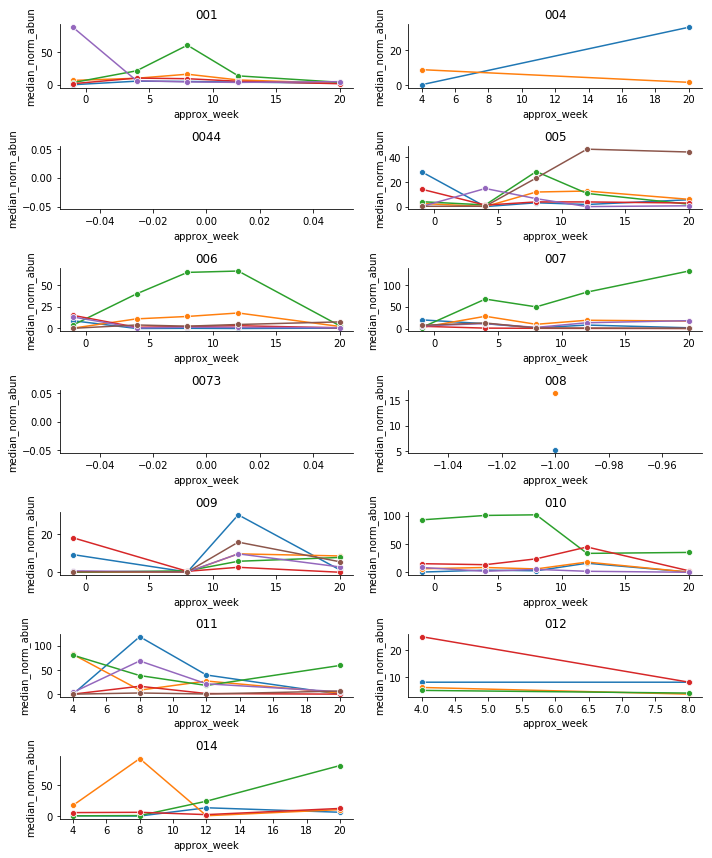

In [114]:
#for each patient, plot these 
fig = plt.figure(figsize = (10,12))

counter = 1
for patient, sub_df in mednorm_tidy.groupby('patient'):
    #ignore any strains that don't have at least a single point with abun > 5
    strain_pass = sub_df.loc[sub_df['median_norm_abun'] > 5]['strain_label'].unique()
    plt_df = sub_df.loc[sub_df['strain_label'].isin(strain_pass)]
    ax = fig.add_subplot(7,2,counter)
    sns.lineplot(x='approx_day', y='median_norm_abun',
                 data=plt_df,
                 hue='strain_label', markers=True,
                 marker="o")
    ax.legend_.remove()
    ax.set_title(patient)
    
    counter += 1

sns.despine()
plt.tight_layout()

## Assigning strains for each genome

We'll assign

In [190]:
def dominant(in_series, method='sum', factor=2, min_val=False):
    """
    By two different methods, identifies dominant features in a series
    
    If method == 'sum', identifies whether one value is
    {factor} times greater than the sum of all other values.
    
    If method == 'second', identifies whether one value is
    {factor} times greater than the next largest feature.
    
    If method == 'order', returns all features that are no more
    than {factor} time greater than the next largest feature.
    
    If method == 'rel_largest', returns all features within a {factor}
    of the largest feature.
    
    If min_val is set, then only values over this number will be output
    """
    max_val = in_series.max()
    results = []
    if method == 'sum':
        if max_val > factor * (in_series.sum() - max_val):
            results.extend(in_series.idxmax())
        else:
            return None
    elif method == 'second':
        series_sorted = in_series.sort_values(ascending=False)
        if in_series.notnull().sum() == 1:
            results.extend(in_series.idxmax())
        elif max_val > factor * (in_series.nlargest(2)[1]):
            results.extend(in_series.idxmax())
        else:
            return None
    elif method == 'order':
        series_sorted = in_series.sort_values(ascending=False)
        ids = series_sorted.index.tolist()
        zipped = zip(series_sorted, series_sorted.iloc[1:])
        tmp_results = []
        for i, [a, b] in enumerate(zipped):
            tmp_results.append(ids[i])
            if a > factor * b:
                break
            elif np.isnan(b):
                break
        results.extend(tmp_results)
    elif method == 'rel_largest':
        tmp_results = []
        for i, x in in_series.iteritems():
            if x > max_val / factor:
                tmp_results.append(i)
        results.extend(tmp_results)
    
    if min_val:
        passing = set(in_series.loc[in_series > min_val].index)
        results = [x for x in results if x in passing]
    return results

In [219]:
#let's assign strain identities for each of these genomes for each patient
strain_source_dfs = []

for gen, s_file, otu_file in zip(gens, s_files, otu_files):
    sam_df = pd.read_csv(f'{s_file_dir}/{s_file}', sep='\t',
                         dtype={'patient': object})
    otu_df = pd.read_csv(f'{otu_file_dir}/{otu_file}', sep='\t')
    
    #add sample info, doing donors by hand
    sam_df.loc[:, 'patient'] = sam_df['patient'].apply(lambda x: x.zfill(3))
    sam_df.loc[:, 'patient'] = sam_df['patient'].replace({'044': '0044', #fix donors
                                                          '073': '0073'})
    sam_df.loc[:, 'ts_group'] = sam_df['ts_group'].fillna('')
    sam_df.loc[:, 'sample'] = sam_df['patient'].str.cat(sam_df['ts_group'], sep='_')
    sam_df.loc[:, 'sample'] = sam_df['sample'].replace({'0044_': '0044', #fix donors
                                                        '0073_': '0073'})
    otu_df.index = sam_df['sample']

    #swap otu labels
    seq_to_label = {seq: f'strain_{x}' for x, seq in zip(range(otu_df.shape[1]), otu_df.columns)}
    strain_id_dict = {v: k for k, v in seq_to_label.items()}
    otu_df.columns = [seq_to_label[x] for x in otu_df.columns]

    #make a table of abundance normalized by median read depth across sites
    otu_mednorm = otu_df.multiply(sam_df.set_index('sample')['quantile_50'], axis=0)
    
    #make a tidy frame
    df = pd.melt(otu_mednorm.reset_index(), 
                 id_vars='sample', var_name='strain_label',
                 value_name='median_norm_abun')

    #add metadata
    df = df.merge(md_ts_comb, 
                  left_on='sample', 
                  right_on='sample_ts_comb')
    
    #get the donor strains
    if '0044' in otu_mednorm.index:
        df_44 = df.loc[df['patient'] == '0044']
        domstr_44 = dominant(df_44.set_index('strain_label')['median_norm_abun'], 
                             method='order', min_val=10)
        #add this information to the results
        df_44.loc[:, 'source'] = ['donor' if x in domstr_44 else 'env' for x in df_44['strain_label']]
        df_44.loc[:, 'genome'] = gen
        df_44.loc[:, 'strain_id'] = df_44['strain_label'].apply(lambda x: strain_id_dict[x])
        strain_source_dfs.append(df_44)
    
    if '0073' in otu_mednorm.index:
        df_73 = df.loc[df['patient'] == '0073']
        domstr_73 = dominant(df_73.set_index('strain_label')['median_norm_abun'], 
                             method='order', min_val=10)
        #add this information to the results
        df_73.loc[:, 'source'] = ['donor' if x in domstr_73 else 'env' for x in df_73['strain_label']]
        df_73.loc[:, 'genome'] = gen
        df_73.loc[:, 'strain_id'] = df_73['strain_label'].apply(lambda x: strain_id_dict[x])
        strain_source_dfs.append(df_73)
    
    #for each patient, go thru the otu table
    for patient, sub_df in df.groupby('patient'):
        #is the patient present?
        if patient in ['0044', '0073']:
            continue
        elif sub_df.shape[0] <= 2:
            continue
        
        #reset strains
        domstr_bl = []
        
        #define patient strains ts_comb
        bl_df = sub_df.loc[sub_df['ts_comb'] == 'baseline'].set_index('strain_label')
        if bl_df.shape[0] > 0:
            domstr_bl = dominant(bl_df['median_norm_abun'], 
                                 method='order', min_val=10)
        
        #define the strains as donor, recipient, shared, or unknown
        #we'll ignore the changing FMT schedule for now
        if sub_df['treatment'].iloc[0] == 'fmt':
            donor = sub_df['fmt_induction'].iloc[0]
            if donor == '0044':
                donor_strains = domstr_44
            elif donor == '0073':
                donor_strains = domstr_73
            
            strain_sources = {}
            for strain in sub_df['strain_label'].values:
                if strain in donor_strains:
                    if strain in domstr_bl:
                        strain_sources[strain] = 'shared'
                    else:
                        strain_sources[strain] = 'donor_any'
                elif strain in domstr_bl:
                    strain_sources[strain] = 'patient'
                else:
                    strain_sources[strain] = 'env'
            
            sub_df.loc[:, 'source'] = sub_df['strain_label'].apply(lambda x: strain_sources[x])
            sub_df.loc[:, 'genome'] = gen
            sub_df.loc[:, 'strain_seq'] = sub_df['strain_label'].apply(lambda x: strain_id_dict[x])
            
            strain_source_dfs.append(sub_df)
            
strain_source_df = pd.concat(strain_source_dfs)

/Users/ndchu/programs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:102: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [220]:
#write this to a file
strain_source_df.to_csv('/Users/ndchu/Documents/uc_fmt/metagenomics/strain_finder/strain_source_results_2019-04-15.tsv.gz',
                        sep='\t', compression='gzip', index=False)

In [11]:
#read this file
strain_source_df = pd.read_csv('/Users/ndchu/Documents/uc_fmt/metagenomics/strain_finder/strain_source_results_2019-04-15.tsv.gz',
                               sep='\t', compression='gzip',
                               dtype={'patient': 'object',
                                      'fmt': 'object',
                                      'fmt_induction': 'object'})

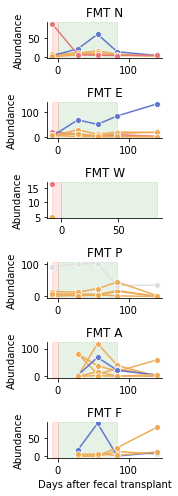

In [253]:
plt_df = strain_source_df.loc[strain_source_df['genome'] == 'faecalibacterium_prausnitzii_GCF_000162015.1_amphora']
plt_df = plt_df.loc[plt_df['treatment'] == 'fmt']

fig = plt.figure(figsize = (2.5,7))

counter = 1
for patient, sub_df in plt_df.groupby('patient'):
    #ignore any strains that don't have at least a single point with abun > 5
    strain_pass = sub_df.loc[sub_df['median_norm_abun'] > 5]['strain_label'].unique()
    sub_df = sub_df.loc[sub_df['strain_label'].isin(strain_pass)]
    
    #get colors
    source_colors = sub_df.set_index('strain_label').to_dict()['source']
    source_colors = {k: src_set_clrs[v] for k, v in source_colors.items()}
    
    ax = fig.add_subplot(6,1,counter)
    sns.lineplot(x='approx_day', y='median_norm_abun',
                 data=sub_df,
                 hue='strain_label', 
                 palette=source_colors,
                 markers=True, marker="o")
    
    #label regions of the graph
    ax.axvspan(-8, 0, alpha=0.1, color='red') #antibiotics
    ax.axvspan(0, 84, alpha=0.1, color='green') #capsules
    
    ax.legend_.remove()
    ax.set_title(patient_ids[patient])
    ax.set_ylabel('Abundance')
    if counter == 6:
        ax.set_xlabel('Days after fecal transplant')
    else:
        ax.set_xlabel('')
    
    counter += 1

sns.despine()
plt.tight_layout()

plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/sf_fp_combsam_2019-04-25.pdf',
            dpi=300)
plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/sf_fp_combsam_2019-04-25.png',
            dpi=300)

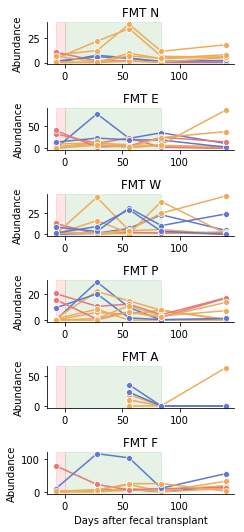

In [222]:
plt_df = strain_source_df.loc[strain_source_df['genome'] == 'bacteroides_caccae_GCF_002222615.2_amphora']
plt_df = plt_df.loc[plt_df['treatment'] == 'fmt']

fig = plt.figure(figsize = (2.5,7))

counter = 1
for patient, sub_df in plt_df.groupby('patient'):
    #ignore any strains that don't have at least a single point with abun > 5
    strain_pass = sub_df.loc[sub_df['median_norm_abun'] > 5]['strain_label'].unique()
    sub_df = sub_df.loc[sub_df['strain_label'].isin(strain_pass)]
    
    #get colors
    source_colors = sub_df.set_index('strain_label').to_dict()['source']
    source_colors = {k: src_set_clrs[v] for k, v in source_colors.items()}
    
    ax = fig.add_subplot(6,1,counter)
    sns.lineplot(x='approx_day', y='median_norm_abun',
                 data=sub_df,
                 hue='strain_label', 
                 palette=source_colors,
                 markers=True, marker="o")
    
    #label regions of the graph
    ax.axvspan(-8, 0, alpha=0.1, color='red') #antibiotics
    ax.axvspan(0, 84, alpha=0.1, color='green') #capsules
    
    ax.legend_.remove()
    ax.set_title(patient_ids[patient])
    ax.set_ylabel('Abundance')
    if counter == 6:
        ax.set_xlabel('Days after fecal transplant')
    else:
        ax.set_xlabel('')
    
    counter += 1

sns.despine()
plt.tight_layout()

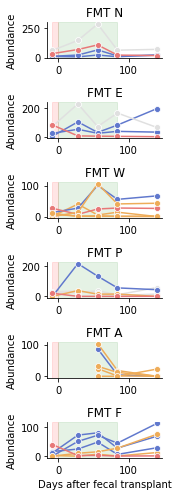

In [246]:
plt_df = strain_source_df.loc[strain_source_df['genome'] == 'bacteroides_dorei_GCF_001640865.1_amphora']
plt_df = plt_df.loc[plt_df['treatment'] == 'fmt']

fig = plt.figure(figsize = (2.5,7))

counter = 1
for patient, sub_df in plt_df.groupby('patient'):
    #ignore any strains that don't have at least a single point with abun > 5
    strain_pass = sub_df.loc[sub_df['median_norm_abun'] > 5]['strain_label'].unique()
    sub_df = sub_df.loc[sub_df['strain_label'].isin(strain_pass)]
    
    #get colors
    source_colors = sub_df.set_index('strain_label').to_dict()['source']
    source_colors = {k: src_set_clrs[v] for k, v in source_colors.items()}
    
    ax = fig.add_subplot(6,1,counter)
    sns.lineplot(x='approx_day', y='median_norm_abun',
                 data=sub_df,
                 hue='strain_label', 
                 palette=source_colors,
                 markers=True, marker="o")
    
    #label regions of the graph
    ax.axvspan(-8, 0, alpha=0.1, color='red') #antibiotics
    ax.axvspan(0, 84, alpha=0.1, color='green') #capsules
    
    ax.legend_.remove()
    ax.set_title(patient_ids[patient])
    ax.set_ylabel('Abundance')
    if counter == 6:
        ax.set_xlabel('Days after fecal transplant')
    else:
        ax.set_xlabel('')
    
    counter += 1

sns.despine()
plt.tight_layout()

plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/sf_bd_combsam_2019-04-25.pdf',
            dpi=300)
plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/sf_bd_combsam_2019-04-25.png',
            dpi=300)

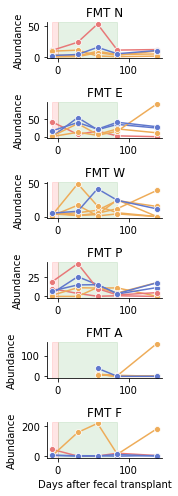

In [14]:
plt_df = strain_source_df.loc[strain_source_df['genome'] == 'bacteroides_fragilis_GCF_000009925.1_amphora']
plt_df = plt_df.loc[plt_df['treatment'] == 'fmt']

fig = plt.figure(figsize = (2.5,7))

counter = 1
for patient, sub_df in plt_df.groupby('patient'):
    #ignore any strains that don't have at least a single point with abun > 5
    strain_pass = sub_df.loc[sub_df['median_norm_abun'] > 5]['strain_label'].unique()
    sub_df = sub_df.loc[sub_df['strain_label'].isin(strain_pass)]
    
    #get colors
    source_colors = sub_df.set_index('strain_label').to_dict()['source']
    source_colors = {k: src_set_clrs[v] for k, v in source_colors.items()}
    
    ax = fig.add_subplot(6,1,counter)
    sns.lineplot(x='approx_day', y='median_norm_abun',
                 data=sub_df,
                 hue='strain_label', 
                 palette=source_colors,
                 markers=True, marker="o")
    
    #label regions of the graph
    ax.axvspan(-8, 0, alpha=0.1, color='red') #antibiotics
    ax.axvspan(0, 84, alpha=0.1, color='green') #capsules
    
    ax.legend_.remove()
    ax.set_title(patient_ids[patient])
    ax.set_ylabel('Abundance')
    if counter == 6:
        ax.set_xlabel('Days after fecal transplant')
    else:
        ax.set_xlabel('')
    
    counter += 1

sns.despine()
plt.tight_layout()

plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/sf_bfrag_combsam_2019-05-05.pdf',
            dpi=300)
plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/sf_bfrag_combsam_2019-05-05.png',
            dpi=300)

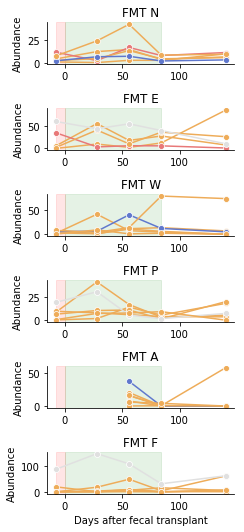

In [230]:
plt_df = strain_source_df.loc[strain_source_df['genome'] == 'bacteroides_ovatus_GCF_001314995.1_amphora']
plt_df = plt_df.loc[plt_df['treatment'] == 'fmt']

fig = plt.figure(figsize = (3.5,7.5))

counter = 1
for patient, sub_df in plt_df.groupby('patient'):
    #ignore any strains that don't have at least a single point with abun > 5
    strain_pass = sub_df.loc[sub_df['median_norm_abun'] > 5]['strain_label'].unique()
    sub_df = sub_df.loc[sub_df['strain_label'].isin(strain_pass)]
    
    #get colors
    source_colors = sub_df.set_index('strain_label').to_dict()['source']
    source_colors = {k: src_set_clrs[v] for k, v in source_colors.items()}
    
    ax = fig.add_subplot(6,1,counter)
    sns.lineplot(x='approx_day', y='median_norm_abun',
                 data=sub_df,
                 hue='strain_label', 
                 palette=source_colors,
                 markers=True, marker="o")
    
    #label regions of the graph
    ax.axvspan(-8, 0, alpha=0.1, color='red') #antibiotics
    ax.axvspan(0, 84, alpha=0.1, color='green') #capsules
    
    ax.legend_.remove()
    ax.set_title(patient_ids[patient])
    ax.set_ylabel('Abundance')
    if counter == 6:
        ax.set_xlabel('Days after fecal transplant')
    else:
        ax.set_xlabel('')
    
    counter += 1

sns.despine()
plt.tight_layout()

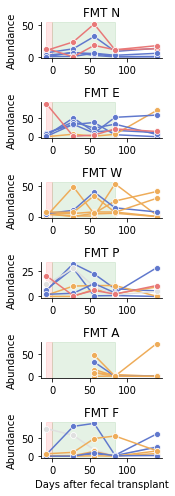

In [15]:
plt_df = strain_source_df.loc[strain_source_df['genome'] == 'bacteroides_thetaiotaomicron_GCF_000011065.1_amphora']
plt_df = plt_df.loc[plt_df['treatment'] == 'fmt']

fig = plt.figure(figsize = (2.5,7))

counter = 1
for patient, sub_df in plt_df.groupby('patient'):
    #ignore any strains that don't have at least a single point with abun > 5
    strain_pass = sub_df.loc[sub_df['median_norm_abun'] > 5]['strain_label'].unique()
    sub_df = sub_df.loc[sub_df['strain_label'].isin(strain_pass)]
    
    #get colors
    source_colors = sub_df.set_index('strain_label').to_dict()['source']
    source_colors = {k: src_set_clrs[v] for k, v in source_colors.items()}
    
    ax = fig.add_subplot(6,1,counter)
    sns.lineplot(x='approx_day', y='median_norm_abun',
                 data=sub_df,
                 hue='strain_label', 
                 palette=source_colors,
                 markers=True, marker="o")
    
    #label regions of the graph
    ax.axvspan(-8, 0, alpha=0.1, color='red') #antibiotics
    ax.axvspan(0, 84, alpha=0.1, color='green') #capsules
    
    ax.legend_.remove()
    ax.set_title(patient_ids[patient])
    ax.set_ylabel('Abundance')
    if counter == 6:
        ax.set_xlabel('Days after fecal transplant')
    else:
        ax.set_xlabel('')
    
    counter += 1

sns.despine()
plt.tight_layout()

plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/sf_btheta_combsam_2019-05-05.pdf',
            dpi=300)
plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/sf_btheta_combsam_2019-05-05.png',
            dpi=300)

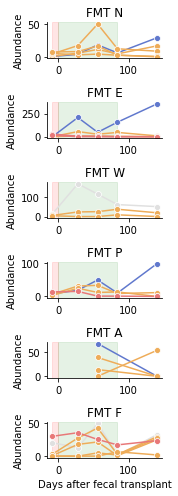

In [247]:
plt_df = strain_source_df.loc[strain_source_df['genome'] == 'bacteroides_uniformis_GCF_000154205.1_amphora']
plt_df = plt_df.loc[plt_df['treatment'] == 'fmt']

fig = plt.figure(figsize = (2.5,7))

counter = 1
for patient, sub_df in plt_df.groupby('patient'):
    #ignore any strains that don't have at least a single point with abun > 5
    strain_pass = sub_df.loc[sub_df['median_norm_abun'] > 5]['strain_label'].unique()
    sub_df = sub_df.loc[sub_df['strain_label'].isin(strain_pass)]
    
    #get colors
    source_colors = sub_df.set_index('strain_label').to_dict()['source']
    source_colors = {k: src_set_clrs[v] for k, v in source_colors.items()}
    
    ax = fig.add_subplot(6,1,counter)
    sns.lineplot(x='approx_day', y='median_norm_abun',
                 data=sub_df,
                 hue='strain_label', 
                 palette=source_colors,
                 markers=True, marker="o")
    
    #label regions of the graph
    ax.axvspan(-8, 0, alpha=0.1, color='red') #antibiotics
    ax.axvspan(0, 84, alpha=0.1, color='green') #capsules
    
    ax.legend_.remove()
    ax.set_title(patient_ids[patient])
    ax.set_ylabel('Abundance')
    if counter == 6:
        ax.set_xlabel('Days after fecal transplant')
    else:
        ax.set_xlabel('')
    
    counter += 1

sns.despine()
plt.tight_layout()

plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/sf_bu_combsam_2019-04-25.pdf',
            dpi=300)
plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/sf_bu_combsam_2019-04-25.png',
            dpi=300)

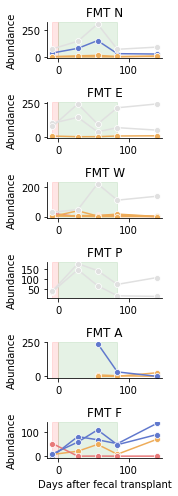

In [254]:
plt_df = strain_source_df.loc[strain_source_df['genome'] == 'bacteroides_vulgatus_GCF_000012825.1_amphora']
plt_df = plt_df.loc[plt_df['treatment'] == 'fmt']

fig = plt.figure(figsize = (2.5,7))

counter = 1
for patient, sub_df in plt_df.groupby('patient'):
    #ignore any strains that don't have at least a single point with abun > 5
    strain_pass = sub_df.loc[sub_df['median_norm_abun'] > 5]['strain_label'].unique()
    sub_df = sub_df.loc[sub_df['strain_label'].isin(strain_pass)]
    
    #get colors
    source_colors = sub_df.set_index('strain_label').to_dict()['source']
    source_colors = {k: src_set_clrs[v] for k, v in source_colors.items()}
    
    ax = fig.add_subplot(6,1,counter)
    sns.lineplot(x='approx_day', y='median_norm_abun',
                 data=sub_df,
                 hue='strain_label', 
                 palette=source_colors,
                 markers=True, marker="o")
    
    #label regions of the graph
    ax.axvspan(-8, 0, alpha=0.1, color='red') #antibiotics
    ax.axvspan(0, 84, alpha=0.1, color='green') #capsules
    
    ax.legend_.remove()
    ax.set_title(patient_ids[patient])
    ax.set_ylabel('Abundance')
    if counter == 6:
        ax.set_xlabel('Days after fecal transplant')
    else:
        ax.set_xlabel('')
    
    counter += 1

sns.despine()
plt.tight_layout()

plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/sf_bv_combsam_2019-04-25.pdf',
            dpi=300)
plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/sf_bv_combsam_2019-04-25.png',
            dpi=300)

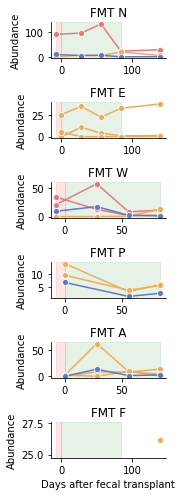

In [16]:
plt_df = strain_source_df.loc[strain_source_df['genome'] == 'bifidobacterium_longum_GCF_000007525.1_amphora']
plt_df = plt_df.loc[plt_df['treatment'] == 'fmt']

fig = plt.figure(figsize = (2.5,7))

counter = 1
for patient, sub_df in plt_df.groupby('patient'):
    #ignore any strains that don't have at least a single point with abun > 5
    strain_pass = sub_df.loc[sub_df['median_norm_abun'] > 5]['strain_label'].unique()
    sub_df = sub_df.loc[sub_df['strain_label'].isin(strain_pass)]
    
    #get colors
    source_colors = sub_df.set_index('strain_label').to_dict()['source']
    source_colors = {k: src_set_clrs[v] for k, v in source_colors.items()}
    
    ax = fig.add_subplot(6,1,counter)
    sns.lineplot(x='approx_day', y='median_norm_abun',
                 data=sub_df,
                 hue='strain_label', 
                 palette=source_colors,
                 markers=True, marker="o")
    
    #label regions of the graph
    ax.axvspan(-8, 0, alpha=0.1, color='red') #antibiotics
    ax.axvspan(0, 84, alpha=0.1, color='green') #capsules
    
    ax.legend_.remove()
    ax.set_title(patient_ids[patient])
    ax.set_ylabel('Abundance')
    if counter == 6:
        ax.set_xlabel('Days after fecal transplant')
    else:
        ax.set_xlabel('')
    
    counter += 1

sns.despine()
plt.tight_layout()

plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/sf_blong_combsam_2019-05-05.pdf',
            dpi=300)
plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/sf_blong_combsam_2019-05-05.png',
            dpi=300)

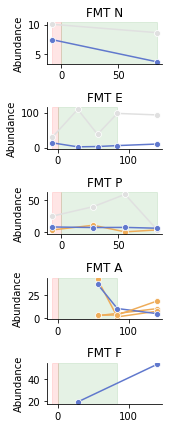

In [17]:
plt_df = strain_source_df.loc[strain_source_df['genome'] == 'BACT_537']
plt_df = plt_df.loc[plt_df['treatment'] == 'fmt']

fig = plt.figure(figsize = (2.5,7))

counter = 1
for patient, sub_df in plt_df.groupby('patient'):
    #ignore any strains that don't have at least a single point with abun > 5
    strain_pass = sub_df.loc[sub_df['median_norm_abun'] > 5]['strain_label'].unique()
    sub_df = sub_df.loc[sub_df['strain_label'].isin(strain_pass)]
    
    #get colors
    source_colors = sub_df.set_index('strain_label').to_dict()['source']
    source_colors = {k: src_set_clrs[v] for k, v in source_colors.items()}
    
    ax = fig.add_subplot(6,1,counter)
    sns.lineplot(x='approx_day', y='median_norm_abun',
                 data=sub_df,
                 hue='strain_label', 
                 palette=source_colors,
                 markers=True, marker="o")
    
    #label regions of the graph
    ax.axvspan(-8, 0, alpha=0.1, color='red') #antibiotics
    ax.axvspan(0, 84, alpha=0.1, color='green') #capsules
    
    ax.legend_.remove()
    ax.set_title(patient_ids[patient])
    ax.set_ylabel('Abundance')
    if counter == 6:
        ax.set_xlabel('Days after fecal transplant')
    else:
        ax.set_xlabel('')
    
    counter += 1

sns.despine()
plt.tight_layout()

plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/sf_eeli_combsam_2019-05-05.pdf',
            dpi=300)
plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/sf_eeli_combsam_2019-05-05.png',
            dpi=300)

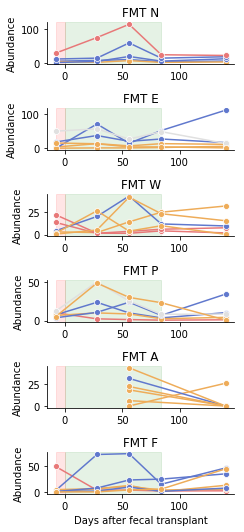

In [237]:
plt_df = strain_source_df.loc[strain_source_df['genome'] == 'BACT_183']
plt_df = plt_df.loc[plt_df['treatment'] == 'fmt']

fig = plt.figure(figsize = (3.5,7.5))

counter = 1
for patient, sub_df in plt_df.groupby('patient'):
    #ignore any strains that don't have at least a single point with abun > 5
    strain_pass = sub_df.loc[sub_df['median_norm_abun'] > 5]['strain_label'].unique()
    sub_df = sub_df.loc[sub_df['strain_label'].isin(strain_pass)]
    
    #get colors
    source_colors = sub_df.set_index('strain_label').to_dict()['source']
    source_colors = {k: src_set_clrs[v] for k, v in source_colors.items()}
    
    ax = fig.add_subplot(6,1,counter)
    sns.lineplot(x='approx_day', y='median_norm_abun',
                 data=sub_df,
                 hue='strain_label', 
                 palette=source_colors,
                 markers=True, marker="o")
    
    #label regions of the graph
    ax.axvspan(-8, 0, alpha=0.1, color='red') #antibiotics
    ax.axvspan(0, 84, alpha=0.1, color='green') #capsules
    
    ax.legend_.remove()
    ax.set_title(patient_ids[patient])
    ax.set_ylabel('Abundance')
    if counter == 6:
        ax.set_xlabel('Days after fecal transplant')
    else:
        ax.set_xlabel('')
    
    counter += 1

sns.despine()
plt.tight_layout()

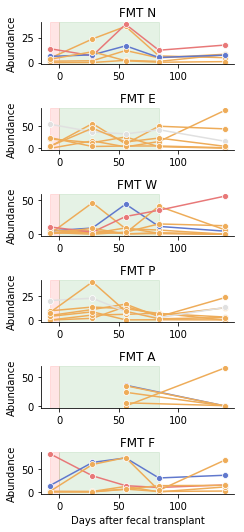

In [238]:
plt_df = strain_source_df.loc[strain_source_df['genome'] == 'BACT_178']
plt_df = plt_df.loc[plt_df['treatment'] == 'fmt']

fig = plt.figure(figsize = (3.5,7.5))

counter = 1
for patient, sub_df in plt_df.groupby('patient'):
    #ignore any strains that don't have at least a single point with abun > 5
    strain_pass = sub_df.loc[sub_df['median_norm_abun'] > 5]['strain_label'].unique()
    sub_df = sub_df.loc[sub_df['strain_label'].isin(strain_pass)]
    
    #get colors
    source_colors = sub_df.set_index('strain_label').to_dict()['source']
    source_colors = {k: src_set_clrs[v] for k, v in source_colors.items()}
    
    ax = fig.add_subplot(6,1,counter)
    sns.lineplot(x='approx_day', y='median_norm_abun',
                 data=sub_df,
                 hue='strain_label', 
                 palette=source_colors,
                 markers=True, marker="o")
    
    #label regions of the graph
    ax.axvspan(-8, 0, alpha=0.1, color='red') #antibiotics
    ax.axvspan(0, 84, alpha=0.1, color='green') #capsules
    
    ax.legend_.remove()
    ax.set_title(patient_ids[patient])
    ax.set_ylabel('Abundance')
    if counter == 6:
        ax.set_xlabel('Days after fecal transplant')
    else:
        ax.set_xlabel('')
    
    counter += 1

sns.despine()
plt.tight_layout()

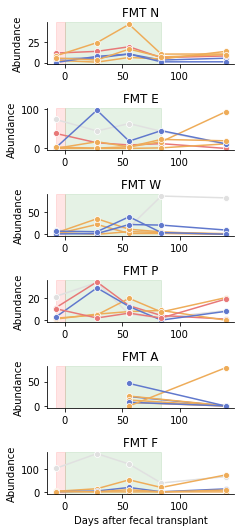

In [239]:
plt_df = strain_source_df.loc[strain_source_df['genome'] == 'BACT_1316']
plt_df = plt_df.loc[plt_df['treatment'] == 'fmt']

fig = plt.figure(figsize = (3.5,7.5))

counter = 1
for patient, sub_df in plt_df.groupby('patient'):
    #ignore any strains that don't have at least a single point with abun > 5
    strain_pass = sub_df.loc[sub_df['median_norm_abun'] > 5]['strain_label'].unique()
    sub_df = sub_df.loc[sub_df['strain_label'].isin(strain_pass)]
    
    #get colors
    source_colors = sub_df.set_index('strain_label').to_dict()['source']
    source_colors = {k: src_set_clrs[v] for k, v in source_colors.items()}
    
    ax = fig.add_subplot(6,1,counter)
    sns.lineplot(x='approx_day', y='median_norm_abun',
                 data=sub_df,
                 hue='strain_label', 
                 palette=source_colors,
                 markers=True, marker="o")
    
    #label regions of the graph
    ax.axvspan(-8, 0, alpha=0.1, color='red') #antibiotics
    ax.axvspan(0, 84, alpha=0.1, color='green') #capsules
    
    ax.legend_.remove()
    ax.set_title(patient_ids[patient])
    ax.set_ylabel('Abundance')
    if counter == 6:
        ax.set_xlabel('Days after fecal transplant')
    else:
        ax.set_xlabel('')
    
    counter += 1

sns.despine()
plt.tight_layout()

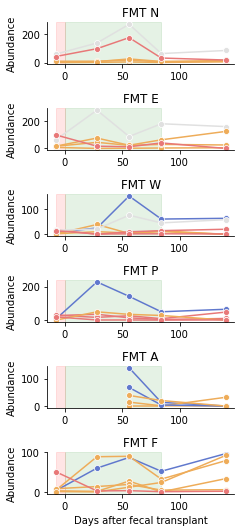

In [240]:
plt_df = strain_source_df.loc[strain_source_df['genome'] == 'BACT_1319']
plt_df = plt_df.loc[plt_df['treatment'] == 'fmt']

fig = plt.figure(figsize = (3.5,7.5))

counter = 1
for patient, sub_df in plt_df.groupby('patient'):
    #ignore any strains that don't have at least a single point with abun > 5
    strain_pass = sub_df.loc[sub_df['median_norm_abun'] > 5]['strain_label'].unique()
    sub_df = sub_df.loc[sub_df['strain_label'].isin(strain_pass)]
    
    #get colors
    source_colors = sub_df.set_index('strain_label').to_dict()['source']
    source_colors = {k: src_set_clrs[v] for k, v in source_colors.items()}
    
    ax = fig.add_subplot(6,1,counter)
    sns.lineplot(x='approx_day', y='median_norm_abun',
                 data=sub_df,
                 hue='strain_label', 
                 palette=source_colors,
                 markers=True, marker="o")
    
    #label regions of the graph
    ax.axvspan(-8, 0, alpha=0.1, color='red') #antibiotics
    ax.axvspan(0, 84, alpha=0.1, color='green') #capsules
    
    ax.legend_.remove()
    ax.set_title(patient_ids[patient])
    ax.set_ylabel('Abundance')
    if counter == 6:
        ax.set_xlabel('Days after fecal transplant')
    else:
        ax.set_xlabel('')
    
    counter += 1

sns.despine()
plt.tight_layout()

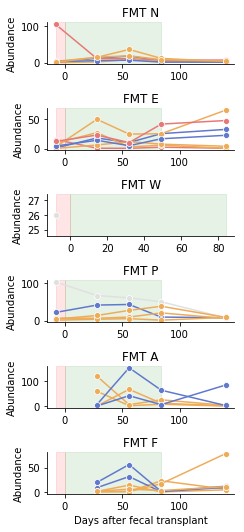

In [242]:
plt_df = strain_source_df.loc[strain_source_df['genome'] == 'BACT_546']
plt_df = plt_df.loc[plt_df['treatment'] == 'fmt']

fig = plt.figure(figsize = (3.5,7.5))

counter = 1
for patient, sub_df in plt_df.groupby('patient'):
    #ignore any strains that don't have at least a single point with abun > 5
    strain_pass = sub_df.loc[sub_df['median_norm_abun'] > 5]['strain_label'].unique()
    sub_df = sub_df.loc[sub_df['strain_label'].isin(strain_pass)]
    
    #get colors
    source_colors = sub_df.set_index('strain_label').to_dict()['source']
    source_colors = {k: src_set_clrs[v] for k, v in source_colors.items()}
    
    ax = fig.add_subplot(6,1,counter)
    sns.lineplot(x='approx_day', y='median_norm_abun',
                 data=sub_df,
                 hue='strain_label', 
                 palette=source_colors,
                 markers=True, marker="o")
    
    #label regions of the graph
    ax.axvspan(-8, 0, alpha=0.1, color='red') #antibiotics
    ax.axvspan(0, 84, alpha=0.1, color='green') #capsules
    
    ax.legend_.remove()
    ax.set_title(patient_ids[patient])
    ax.set_ylabel('Abundance')
    if counter == 6:
        ax.set_xlabel('Days after fecal transplant')
    else:
        ax.set_xlabel('')
    
    counter += 1

sns.despine()
plt.tight_layout()

In [235]:
[[x, bact_id_to_gen[x]] if x in bact_id_to_gen else x for x in gens]

[['BACT_1316', 'Bacteroides_sp._3_1_23'],
 ['BACT_1319', 'Bacteroides_sp._D4'],
 ['BACT_1555', 'Bifidobacterium_longum_subsp._longum_JDM301'],
 ['BACT_171', 'Bacteroides_caccae_ATCC_43185'],
 ['BACT_173', 'Bacteroides_cellulosilyticus_DSM_14838'],
 ['BACT_174', 'Bacteroides_coprocola_DSM_17136'],
 ['BACT_175', 'Bacteroides_coprophilus_DSM_18228'],
 ['BACT_177', 'Bacteroides_eggerthii_DSM_20697'],
 ['BACT_178', 'Bacteroides_finegoldii_DSM_17565'],
 ['BACT_183', 'Bacteroides_plebeius_DSM_17135'],
 ['BACT_194', 'Bacteroides_stercoris_ATCC_43183'],
 ['BACT_195', 'Bacteroides_thetaiotaomicron_VPI-5482'],
 ['BACT_196', 'Bacteroides_vulgatus_ATCC_8482'],
 ['BACT_219', 'Bifidobacterium_longum_subsp._infantis_ATCC_15697'],
 ['BACT_220', 'Bifidobacterium_longum_subsp._infantis_CCUG_52486'],
 ['BACT_3004', 'Bacteroides_fragilis_3_1_12'],
 ['BACT_3008', 'Bacteroides_uniformis_ATCC_8492'],
 ['BACT_4029', 'Bacteroides_fragilis_638R'],
 ['BACT_537', 'Eubacterium_eligens_ATCC_27750'],
 ['BACT_545', 'F